## MSDS 7331: Data Mining

## Mini Lab: Logistic Regression and SVMs

## 9 June 2019

## Authors: Meredith Ludlow, Anand Rajan, Kristen Rollins, and Tej Tenmattam

---

### Create Models

<div class="alert alert-block alert-info">
<b>Rubric 1:</b> Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.
</div>

#### Preparing Data

In [17]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set seaborn plot styles
sns.set_style('darkgrid')
sns.set_color_codes('muted')

#uncomment when ready to turn in report
#import warnings
#warnings.filterwarnings("ignore") # ignore warnings for clean report

# df.head() displays all the columns without truncating
pd.set_option('display.max_columns', None)

# read csv file as pandas dataframe
df_17_census = pd.read_csv('Data/acs2017_census_tract_data.csv')

In [18]:
# Clean dataset as in lab 1
df_17_census.set_index('TractId', inplace=True) # set tract id as index

# Drop tracts where population is 0
df_17_cln = df_17_census.drop(df_17_census[df_17_census.TotalPop == 0].index)

# Drop tracts where child poverty or unemployment is null
df_17_cln = df_17_cln[np.isfinite(df_17_cln['ChildPoverty'])]
df_17_cln = df_17_cln[np.isfinite(df_17_cln['Unemployment'])]

# Impute to the median by each state
df_grouped = df_17_cln.groupby('State').transform(lambda x: x.fillna(x.median()))
df_17_cln['Income'] = df_grouped['Income']
df_17_cln['IncomeErr'] = df_grouped['IncomeErr']

# Impute remaining values to the overall median
df_17_cln = df_17_cln.fillna(df_17_cln.median())

In [19]:
# Categorize the unemployed percentages into binary categories
# Make cutoff using median of clean dataset, so groups are roughly equal
df_17_cln['HighUnemployment'] = pd.cut(df_17_cln.Unemployment,[-1,6,101],labels=[0,1])                                 
df_17_cln.HighUnemployment = df_17_cln.HighUnemployment.astype(np.int)
# 0 indicates low unemployment rate, 1 indicates high unemployment rate

df_17_cln.info() # matches cleaned dataset from lab 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 37 columns):
State               72889 non-null object
County              72889 non-null object
TotalPop            72889 non-null int64
Men                 72889 non-null int64
Women               72889 non-null int64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null int64
Income              72889 non-null float64
IncomeErr           72889 non-null float64
IncomePerCap        72889 non-null float64
IncomePerCapErr     72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 

In [20]:
# Create dataframe to use in logistic and SVM models
df_17_model = df_17_cln.copy()

# Eliminate non-useful and redundant variables
del df_17_model['State'] # encoding would result in too many added variables
del df_17_model['County'] # encoding would result in too many added variables
del df_17_model['Men'] # redundant to keep men and women
del df_17_model['Unemployment'] # already encoded to binary

# Eliminate more variables based on correlation plot (TODO maybe remove more)
del df_17_model['IncomeErr'] # only need to keep one income-related variable
del df_17_model['IncomePerCap'] # only need to keep one income-related variable
del df_17_model['IncomePerCapErr'] # only need to keep one income-related variable
del df_17_model['Transit'] # drive and transit were essentially inverses
del df_17_model['PublicWork'] # private and public work were essentially inverses

# All remaining variables are ints or floats so we do not have to do one-hot encoding

# Convert columns to percentages for consistency
df_17_model['Women'] = round(df_17_model['Women']/df_17_model['TotalPop']*100,1)
df_17_model['VotingAgeCitizen'] = round(df_17_model['VotingAgeCitizen']/df_17_model['TotalPop']*100,1)
df_17_model['Employed'] = round(df_17_model['Employed']/df_17_model['TotalPop']*100,1)

# TODO maybe further dimension reduction via PCA

print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


#### Train/Test Split

In [5]:
# Following code from Dr. Larson's Logits and SVM notebook
# Question: should we actually use cross-validation for this lab? (rubric doesn't mention it)
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'HighUnemployment' in df_17_model:
    y = df_17_model['HighUnemployment'].values # get the labels we want
    del df_17_model['HighUnemployment'] # get rid of the class label
    X = df_17_model.values # use everything else to predict
    
# 10 fold cross-validation
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


#### Logistic Regression

In [6]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
# also scale variables
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

# TODO repeat and try out different learning parameters and constants
# TODO try to fix warnings - fixed this with solver
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs') 
        #class_weight=None because unemployment groups are weighted equally

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    # scale attributes by the training set
    scl_obj.fit(X[train_indices])
    X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
    X_test_scaled = scl_obj.transform(X[test_indices]) # use training scales to adjust test set, so we're not cheating
    
    # train object
    lr_clf.fit(X_train_scaled,y[train_indices])
    # get test set precitions
    y_hat = lr_clf.predict(X_test_scaled)

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("Precision:",mt.precision_score(y[test_indices],y_hat))
    print("Recall:",mt.recall_score(y[test_indices],y_hat))
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


====Iteration 0  ====
Precision: 0.7541428141006328
Recall: 0.7039797496835888
accuracy 0.7436548223350253
confusion matrix
 [[5835 1632]
 [2105 5006]]
====Iteration 1  ====
Precision: 0.7667833764652154
Recall: 0.7038848518725545
accuracy 0.7495541226505693
confusion matrix
 [[5890 1532]
 [2119 5037]]
====Iteration 2  ====
Precision: 0.7572918240894665
Recall: 0.69859194200474
accuracy 0.7415283303608177
confusion matrix
 [[5799 1606]
 [2162 5011]]
====Iteration 3  ====
Precision: 0.7612942612942613
Recall: 0.697817571348629
accuracy 0.7445465770338867
confusion matrix
 [[5866 1564]
 [2160 4988]]
====Iteration 4  ====
Precision: 0.7582417582417582
Recall: 0.7064516129032258
accuracy 0.7462614899163122
confusion matrix
 [[5842 1606]
 [2093 5037]]
====Iteration 5  ====
Precision: 0.7651723086306801
Recall: 0.7029980386662931
accuracy 0.7489367540128962
confusion matrix
 [[5900 1540]
 [2120 5018]]
====Iteration 6  ====
Precision: 0.7603495860165593
Recall: 0.6978609625668449
accuracy 0.7

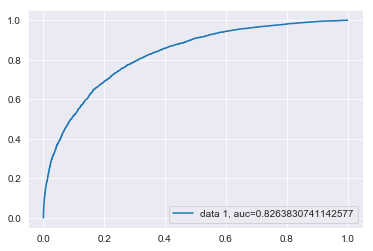

In [7]:
#ROC Curve for LR model above
y_pred_prob = lr_clf.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = mt.roc_curve(y[test_indices],  y_pred_prob)
auc = mt.roc_auc_score(y[test_indices], y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [8]:
# import the necessary packages
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import argparse
 
def sigmoid_activation(x):
# compute and return the sigmoid activation value for a
# given input value
    return 1.0 / (1 + np.exp(-x))

sigmoid_activation(X_train_scaled)
                             

array([[0.44782082, 0.35753757, 0.32287834, ..., 0.74510569, 0.41777225,
        0.4071267 ],
       [0.98357263, 0.58025284, 0.96690713, ..., 0.58301668, 0.43694855,
        0.76005522],
       [0.32272169, 0.64272187, 0.3420621 , ..., 0.07746071, 0.68812633,
        0.4071267 ],
       ...,
       [0.80031283, 0.49116305, 0.35383048, ..., 0.40978904, 0.46930382,
        0.4071267 ],
       [0.65528171, 0.64272187, 0.35978284, ..., 0.49004276, 0.34402594,
        0.4071267 ],
       [0.5802278 , 0.59764064, 0.40257513, ..., 0.42498631, 0.42413975,
        0.4071267 ]])

In [9]:
# Loss function for gradient descent y=0 to y=1 and y_hat is prediction for best value
# weights and bias are updated until we reach bottom (the minimum point)

def log_loss (y, y_hat):
    return -np.mean(y * np.log(y_hat) + (1 -y) * np.log(1-y_hat))

log_loss(y[test_indices],y_hat)
                             

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


nan

ValueError: x and y must be the same size

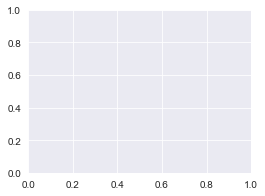

In [27]:
# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

#### Support Vector Machine

In [21]:
print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


In [22]:
### Split into train and test set
import pandas as pd
from sklearn.model_selection import train_test_split

features = df_17_model.drop('HighUnemployment', axis=1)
labels = df_17_model['HighUnemployment']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [23]:
# Display to show that we got 80/20 split
for dataset in [y_train, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.8
0.2


In [24]:
# Function to print the results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

## Find the best tuned hyperplane parameters for Logistic Regression
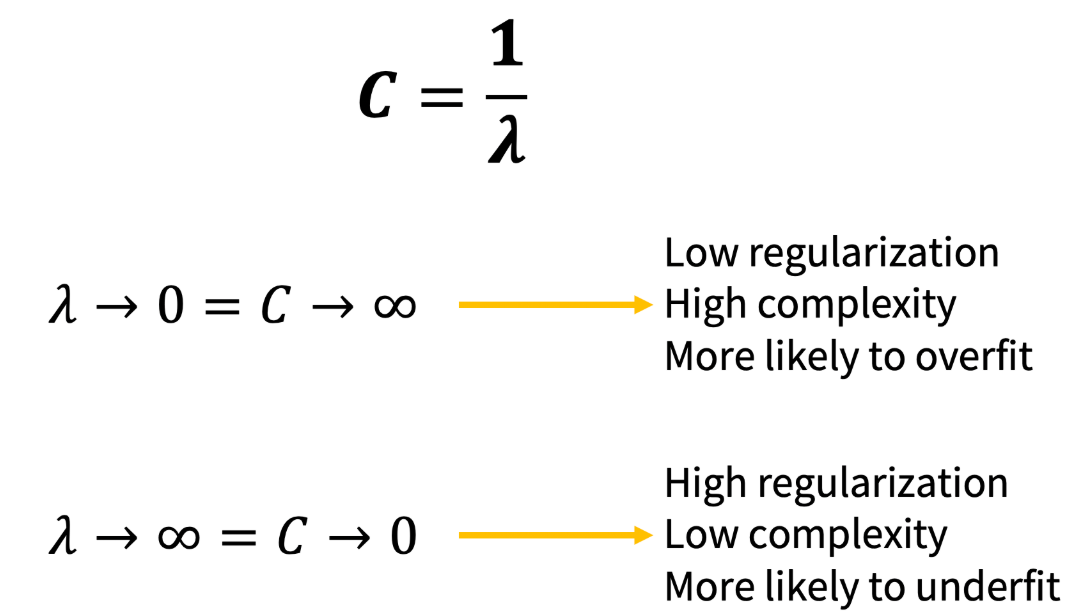

In [25]:
# Find the best hyperplane parameters for Logistic Regression
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv = GridSearchCV(lr, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

BEST PARAMS: {'C': 100}

0.746 (+/-0.008) for {'C': 0.001}
0.746 (+/-0.007) for {'C': 0.01}
0.746 (+/-0.007) for {'C': 0.1}
0.746 (+/-0.007) for {'C': 1}
0.746 (+/-0.007) for {'C': 10}
0.746 (+/-0.007) for {'C': 100}
0.745 (+/-0.008) for {'C': 1000}


In [28]:
# Display the best estimator with the recommended hyperplane parameters
cv.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
# Output this to a model.pkl file
joblib.dump(cv.best_estimator_, 'LR_model.pkl')

['LR_model.pkl']

## Find the best tuned hyperplane parameters for SVM
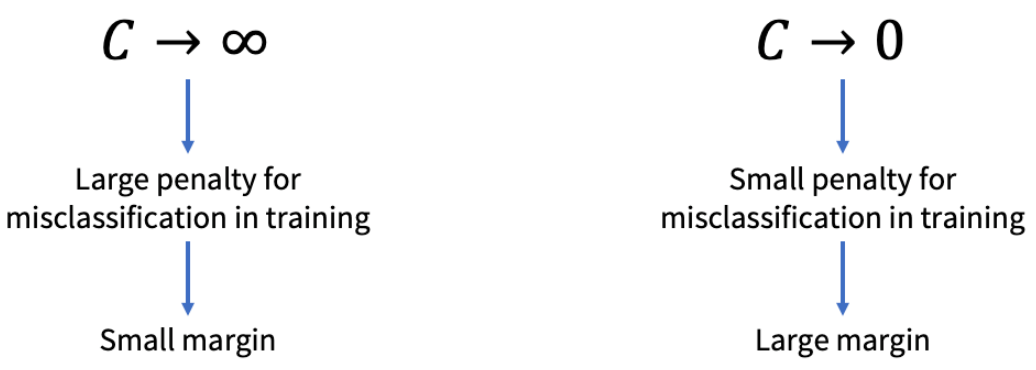

In [30]:
### Support Vector Machines: Fit and evaluate a model
import joblib
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [31]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
#Note: This code is computationally very intensive and takes a long time. First we tried to see the best C value
# between 0.1, 1 and 10 with a cv of 5 but it was taking too many hours to finish so we decided to use a C of 0.5. 

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.5]
}

cv = GridSearchCV(svc, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())

print_results(cv)

In [ ]:
cv.best_estimator_

In [ ]:
joblib.dump(cv.best_estimator_, 'SVM_model.pkl')

In [32]:
# Read in Models:
models = {}

for mdl in ['LR', 'SVM']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))

In [33]:
models

{'LR': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'SVM': SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='linear', max_iter=-1, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)}

In [34]:
# Evaluate models on the test set
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [35]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

LR -- Accuracy: 0.743 / Precision: 0.753 / Recall: 0.704 / Latency: 3.4ms
SVM -- Accuracy: 0.736 / Precision: 0.769 / Recall: 0.657 / Latency: 5448.8ms


### Model Advantages

<div class="alert alert-block alert-info">
<b>Rubric 2:</b> Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</div>

In [36]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

LR -- Accuracy: 0.743 / Precision: 0.753 / Recall: 0.704 / Latency: 2.1ms
SVM -- Accuracy: 0.736 / Precision: 0.769 / Recall: 0.657 / Latency: 5601.5ms


In our case Logistic Regression performed better with an accuracy of 74.3% and recall of 70.4%. However SVM performed better in Precision. Latency for SVM is very high and is very slow to train.

Logistic Regression: 

When to use LR:
- Binary target variable
- Transparency is important or interested in significance of predictors
- Fairly well-behaved data
- Need a quick initial benchmark

Logistic Regression can be considered any time we have a binary target variable and if we are interested in feature importance or to have a better understanding of what's going on within the algorithm. It should be considered when there are not too many outliers, not too many missing values, and relationships that aren't too complex. It is great for as an initial benchmark model on a binary classification problem with fairly well-behaved data. It's relatively flexible, and it's very fast to train. While it doesn't usually generate the greatest performance, it does set a very nice benchmark to start.

When not to use LR:
- Continuous target variable
- Massive data (rows or columns)
- Unwieldy data
- Performance is the only thing that matters

Logistic Regression should not be considered when we have a continuous target variable. Logistic regression also shouldn't be the first choice if we have a massive amount of data. There are other algorithms that really shine when we have a ton of data. Logistic regression is a great tool for a fast, transparent baseline model for a binary classification problem. It doesn't do well with a lot of data or particularly messy data. It's also unlikely to give you the best possible performance on any given problem.


Support Vector Machines:

When to use SVM:

- Binary target variable
- Feature to row ratio is very high
- Very complex relationships
- Lots of outliers

SVM can be used for both categorical and continuous outputs. One area where SVM really excels is when the feature-to-row ratio is very high. It's when you have a lot of features and relatively few rows. SVM is also quite good at untangling complex relationships. SVM also handles data with a lot of outliers quite well, because it only looks at the points closest to the line, so that outliers are kind of ignored. 

When not to use SVM:

- Feature to row ratio is very low
- Transparency is important or interested in significance of predictors
- Looking for a quick benchmark model

SVM should not be used if there are lot of rows and relatively few features. Typically, SVM will take a long time to train, and the performance really won't be worth it relative to other algorithms. Since in SVM hyperplane is an extremely high-dimensional space, you can't really get a good picture what's going on inside of SVM. So if you care about transparency, and maybe the significance of predictors, you should avoid SVM. SVM should be used when you have a lot of features, but few rows, or when you have a lot of outliers, that you're trying to untangle. But it is quite slow to train.

### Interpret Feature Importance

<div class="alert alert-block alert-info">
<b>Rubric 3:</b> Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</div>

In [37]:
# TODO use best logistic model we find (lr_clf object)
# sort attributes by weight and spit them out
zip_vars = zip(lr_clf.coef_.T,df_17_model.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

White has weight of -1.0564485864726945
Employed has weight of -0.6604700499351661
Hispanic has weight of -0.44670008273802325
Black has weight of -0.28009715209467734
Asian has weight of -0.2103970378444884
Income has weight of -0.1721104665694729
Professional has weight of -0.10564657942554963
WorkAtHome has weight of -0.07891518307243915
Pacific has weight of -0.05725714951322543
Construction has weight of -0.05531849868313771
Native has weight of -0.054473131407573115
ChildPoverty has weight of -0.04995837210828966
FamilyWork has weight of -0.03719279918245867
TotalPop has weight of -0.03360444484524141
Walk has weight of -0.02275852366578473
SelfEmployed has weight of -0.018025643675168613
Drive has weight of 0.013539271367579923
PrivateWork has weight of 0.03167466163687593
Office has weight of 0.03983453645429305
OtherTransp has weight of 0.04083194746973828
Carpool has weight of 0.04497913658646876
Production has weight of 0.05374829801482868
Women has weight of 0.0737596264090

### Interpret Support Vectors

<div class="alert alert-block alert-info">
<b>Rubric 4:</b> Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</div>